In [1]:
%matplotlib inline
import torch
import random
import pandas as pd
import numpy as np
import pandas_datareader.data as web
from matplotlib import pyplot
import seaborn as sns
import os

#Plotting 
from pandas.plotting import scatter_matrix

#Libraries for Statistical Models
import statsmodels.api as sm

#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None
pd.options.display.expand_frame_repr = False
pd.options.display.float_format = '{:.3f}'.format

torch.seed = 42
random.seed(42)
np.random.seed(42)

data_dir = f'{os.getcwd()}/data/'
log_dir_base = f'{os.getcwd()}/runs/BuySellSignal'
log_dir = log_dir_base
print(f'{data_dir}\n{log_dir}')

/Volumes/USB/work/fin-ml/data/
/Volumes/USB/work/fin-ml/runs/BuySellSignal


In [2]:
# hyperparameters turning
from ray import tune, train, ray
from ray.tune.schedulers import ASHAScheduler

ray.init(log_to_driver=False)

2024-01-29 16:26:12,240	ERROR services.py:1329 -- Failed to start the dashboard , return code 1
2024-01-29 16:26:12,242	ERROR services.py:1354 -- Error should be written to 'dashboard.log' or 'dashboard.err'. We are printing the last 20 lines for you. See 'https://docs.ray.io/en/master/ray-observability/ray-logging.html#logging-directory-structure' to find where the log file is.
2024-01-29 16:26:12,245	ERROR services.py:1398 -- 
The last 20 lines of /tmp/ray/session_2024-01-29_16-26-10_660913_2136/logs/dashboard.log (it contains the error message from the dashboard): 
    from ray.util.state.common import (
  File "/Users/alex/py_env/ml4t/lib/python3.8/site-packages/ray/util/state/__init__.py", line 1, in <module>
    from ray.util.state.api import (
  File "/Users/alex/py_env/ml4t/lib/python3.8/site-packages/ray/util/state/api.py", line 17, in <module>
    from ray.util.state.common import (
  File "/Users/alex/py_env/ml4t/lib/python3.8/site-packages/ray/util/state/common.py", line 41

Python version:,3.8.18
Ray version:,2.9.1


In [3]:
def get_filename_of_ipynb():
    from IPython import get_ipython
    import os
    ip = get_ipython()
    path = ''
    if '__vsc_ipynb_file__' in ip.user_ns:
        path = ip.user_ns['__vsc_ipynb_file__']

    return '.'.join(os.path.basename(path).split('.')[:-1])

In [4]:
from datetime import datetime
import yfinance as yfin

# Loading the data
stk_tickers = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'TSLA', 'META', 'GOOG', 'ADBE', 'NFLX', 'CSCO', 'INTC', 'INTU', 'CMCSA', 'TXN', 'AMAT', 'ADSK', 'AMD', 'QCOM', 'MU']

start = datetime(2014, 1, 1)
end = datetime(2023, 12, 31)

ticks_data = []
for stk_symbol in stk_tickers:
    stk_file = f"{data_dir}{stk_symbol}.csv"
    bLoad = False
    if os.path.isfile(stk_file):
        try:
            _stk_data = pd.read_csv(stk_file).set_index('Date')
            bLoad = True
            print(f"read {stk_file} completely!")
        except:
            None
    if bLoad == False:
        # _stk_data = web.get_data_yahoo(stk_tickers, start, end)
        _stk_data = yfin.download([stk_symbol], start, end).dropna()
        _stk_data.to_csv(stk_file)
        print(f"download {stk_symbol} from yfin and write to {stk_file} completely!")
    ticks_data.append(_stk_data)

print(ticks_data)

read /Volumes/USB/work/fin-ml/data/AAPL.csv completely!
read /Volumes/USB/work/fin-ml/data/MSFT.csv completely!
read /Volumes/USB/work/fin-ml/data/AMZN.csv completely!
read /Volumes/USB/work/fin-ml/data/NVDA.csv completely!
read /Volumes/USB/work/fin-ml/data/GOOGL.csv completely!
read /Volumes/USB/work/fin-ml/data/TSLA.csv completely!
read /Volumes/USB/work/fin-ml/data/META.csv completely!
read /Volumes/USB/work/fin-ml/data/GOOG.csv completely!
read /Volumes/USB/work/fin-ml/data/ADBE.csv completely!
read /Volumes/USB/work/fin-ml/data/NFLX.csv completely!
read /Volumes/USB/work/fin-ml/data/CSCO.csv completely!
read /Volumes/USB/work/fin-ml/data/INTC.csv completely!
read /Volumes/USB/work/fin-ml/data/INTU.csv completely!
read /Volumes/USB/work/fin-ml/data/CMCSA.csv completely!
read /Volumes/USB/work/fin-ml/data/TXN.csv completely!
read /Volumes/USB/work/fin-ml/data/AMAT.csv completely!
read /Volumes/USB/work/fin-ml/data/ADSK.csv completely!
read /Volumes/USB/work/fin-ml/data/AMD.csv comp

In [19]:
import torch
device_name = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device = torch.device(device_name)
validation_size = 0.2
epoch_num = 100
batch_size = 32
num_workers = 0 #2
pin_memory = True
log_dir_base = f'{os.getcwd()}/runs/{get_filename_of_ipynb()}'
log_dir = log_dir_base
print(log_dir)


/Volumes/USB/work/fin-ml/runs/BuySellSignalPrediction


In [6]:
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn_pandas import DataFrameMapper

def gen_buy_sell_signal(stk_data):
    import pandas_ta as ta

    sma = pd.concat([stk_data.ta.sma(close='Adj Close', length=10), stk_data.ta.sma(close='Adj Close', length=60)], axis=1).dropna()
    buy_signal = (sma['SMA_10'] > sma['SMA_60'])

    buy_sell_signal = stk_data[[]].copy()
    buy_sell_signal['Signal'] = (buy_signal).astype('int')
    # buy_sell_signal['SELL'] = (~buy_signal).astype('float32')

    return buy_sell_signal

def gen_analysis_data(stk_data):
    import pandas_ta as ta

    data = pd.concat([
        stk_data.ta.adosc(),
        stk_data.ta.kvo(),
        stk_data.ta.rsi(close='Adj Close', length=10)/100,
        stk_data.ta.rsi(close='Adj Close', length=30)/100,
        stk_data.ta.rsi(close='Adj Close', length=200)/100,
        stk_data.ta.stoch(k=10)/100,
        stk_data.ta.stoch(k=30)/100,
        stk_data.ta.stoch(k=200)/100,
        gen_buy_sell_signal(stk_data)
        ], 
        axis=1)

    data = data.dropna().astype('float32')
    return data


In [7]:
with pd.option_context('display.max_rows', None,):
    print(gen_analysis_data(ticks_data[0]).head(100))

               ADOSC_3_10  KVO_34_55_13  KVOs_34_55_13  RSI_10  RSI_30  RSI_200  STOCHk_10_3_3  STOCHd_10_3_3  STOCHk_30_3_3  STOCHd_30_3_3  STOCHk_200_3_3  STOCHd_200_3_3  Signal
Date                                                                                                                                                                               
2014-10-22  -45839036.000  -3324833.250  -14716448.000   0.637   0.574    0.578          0.814          0.609          0.794          0.582           0.936           0.882   1.000
2014-10-23   22155916.000   2109229.750  -12312780.000   0.690   0.599    0.582          0.927          0.793          0.926          0.776           0.974           0.932   1.000
2014-10-24   74158712.000   4986560.500   -9841446.000   0.700   0.604    0.583          0.942          0.894          0.942          0.887           0.984           0.965   1.000
2014-10-27   90922280.000   6489589.000   -7508440.500   0.693   0.602    0.583          0.972      

In [22]:
import random
import math
from torch.utils.data import Dataset, DataLoader


class SignalDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (np.array(self.X.iloc[idx, :]), int(self.Y.iloc[idx]))

        # return (torch.tensor(np.array(self.X.iloc[idx, :]), dtype=torch.float32),
        #         int(self.Y.iloc[idx]))


def prepare_dataloader():
    dataset = pd.concat([gen_analysis_data(d) for d in ticks_data])

    test_size = int(dataset.shape[0] * validation_size)
    random.seed(42)
    test_data_idx = random.sample(range(0, dataset.shape[0]), test_size)
    mask = np.full(len(dataset), False)
    mask[test_data_idx] = True
    train_data = dataset[~mask]
    test_data = dataset[mask]

    X_train_data = train_data.iloc[:, :-1]
    Y_train_data = train_data.iloc[:, -1:]

    X_test_data = test_data.iloc[:, :-1]
    Y_test_data = test_data.iloc[:, -1:]

    features = [
        ([column], StandardScaler()) for column in X_train_data.columns[:3].values
    ]
    features.extend([([column], None) for column in X_train_data.columns[3:].values])
    # print(features)
    X_dfm = DataFrameMapper(features, input_df=True, df_out=True)
    X_train_data = X_dfm.fit_transform(X_train_data)
    X_test_data = X_dfm.transform(X_test_data)
 
    train_loader = DataLoader(
        SignalDataset(X_train_data, Y_train_data),
        batch_size,
        shuffle=True,
        num_workers=num_workers,
        # pin_memory=pin_memory,
        # pin_memory_device=device_name,
    )
    test_loader = DataLoader(
        SignalDataset(X_test_data, Y_test_data),
        batch_size=batch_size,
        num_workers=num_workers,
        # pin_memory=pin_memory,
        # pin_memory_device=device_name,
    )

    return train_loader, test_loader, X_train_data.shape[1]

In [9]:
from torch import nn
class BuySellSignalClassifier(nn.Module):
    def __init__(self, input_size, num_layers, activation_type):
        super().__init__()
        self.input_size = input_size
        
        layers = []
        in_features = input_size
        for i in range(1, num_layers):
            out_features = int(in_features / 2)
            if (out_features <= 2):
                break
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.ReLU() if activation_type == 1 else
                          nn.Sigmoid()) if activation_type == 2 else nn.Tanh()
            in_features = out_features
        layers.append(nn.Linear(in_features, 2))
        self.classifier = nn.Sequential(*layers)
        # self.soft_max = nn.LogSoftMax(dim=1)

    def forward(self, x):
        output = self.classifier(x)
        # output = self.soft_max(output)
        return output
    
def save_model(model, hyper_parameters, file_path, epoch_num=None):
    state = {
        'epoch_num': epoch_num,
        'time': str(datetime.now),
        'model_state': model.state_dict(),
        'input_size': model.input_size,
        'hyper_parameters': hyper_parameters
    }
    torch.save(state, file_path)

def load_model(file_path):
    data_dict = torch.load(file_path)
    hyper_parameters = data_dict['hyper_parameters']
    model = BuySellSignalClassifier(
        data_dict['input_size'],
        num_layers=hyper_parameters['num_layers'],
        activation_type=hyper_parameters['activation_type'])
    model.load_state_dict(data_dict['model_state'])
    return model, hyper_parameters


In [10]:
import math 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score

def eval_dl_method(model, dl, device=device):
    model.eval()
    y_gt = []
    y_pred = []
    total = 0
    correct = 0
    f1 = 0
    for x, y in dl:
        x = x.to(device)
        y = y.to(device)
        outputs = model(x)
        _, predicted = torch.max(outputs, dim=1)
        total += y.shape[0]
        correct += int((predicted == y).sum())
        f1 += f1_score(y.cpu().detach(), predicted.cpu().detach())

    accuracy = correct/total
    f1 = f1/len(dl)
    # print(f"Accuracy: {accuracy:.3f}, F1 score:{f1:.3f}")
    return accuracy, f1

In [11]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

import warnings
warnings.filterwarnings('ignore')
_best_loss = 999  
_best_accuracy = 0
def do_train(model, optimizer, train_dl, test_dl, id_str, config):
    global _best_loss
    global _best_accuracy

    criterion = torch.nn.CrossEntropyLoss()

    model_name = f"{log_dir}/{id_str}.pt"
  
    total_loss = 0.0
    total_accuracy = 0.0
    for epoch in tqdm(range(epoch_num), leave=True):
        model.train()
        running_loss = 0.0
        
        for i, (x, y) in enumerate(train_dl):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        with torch.no_grad():
            accuracy, f1  = eval_dl_method(model, test_dl)
            if accuracy > _best_accuracy:
                _best_accuracy = accuracy

            if loss.item() < _best_loss:
                _best_loss = loss.item()
                save_model(model, config, model_name)

            train.report({"mean_accuracy":accuracy})
  
        # writer.add_scalars('Loss vs. Validation Accuracy',
        #                     { 'Loss' : running_loss / len(train_dl), 'Validation Accuracy' : accuracy, 'F1': f1 },
        #                     epoch + 1)

        total_loss += running_loss / len(train_dl)
        total_accuracy += accuracy

        # writer.flush()

    return {'Train loss':total_loss/epoch_num, 'Validation Accuracy': total_accuracy/epoch_num}


In [12]:
def train_classifier(config):
    lr = config["lr"]
    momentum = config["momentum"]
    optim_type = config["optim_type"]
    num_layers = config["num_layers"]
    activation_type = config["activation_type"]

    id_str = f"{lr}_{momentum}_{optim_type}_{num_layers}_{activation_type}"

    # writer = SummaryWriter(f"{log_dir}/{id_str}")    

    train_loader, test_loader, features_size = prepare_dataloader()
    model = BuySellSignalClassifier(features_size, num_layers, activation_type)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) if optim_type == 1 else torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    #metric_dict = do_train(model, optimizer, train_loader, test_loader, id_str, config, writer)
    do_train(model, optimizer, train_loader, test_loader, id_str, config)
    # writer.add_hparams(
    #     {
    #         "lr": lr,
    #         "momentum": momentum,
    #         "optim_type": optim_type,
    #         "num_layers": num_layers,
    #         "activation_type": activation_type
    #     },
    #     metric_dict
    # )
    # writer.close()


In [23]:
# train_loader, test_loader, features_size = prepare_dataloader()
# model = BuySellSignalClassifier(features_size, 3, 1)
# model = model.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# time_str = datetime.now().strftime('%Y-%m-%d_%H.%M.%S')
# log_dir = f'{log_dir_base}/{time_str}'
# id_str = f"0.01_4_test"
config={
    "lr":0.001,
    "momentum":0.32400661960813776,
    "optim_type":2,
    "num_layers":4,
    "activation_type":2
}

# writer = SummaryWriter(f"{log_dir}/{id_str}")
# print(f"num_workers={num_workers}")
pin_memory=True
print(f"pin_memory={pin_memory}")
start = datetime.now()
train_classifier(config)
print(f"Elasped time:{datetime.now() - start}")

# pin_memory=False
# print(f"pin_memory={pin_memory}")
# start = datetime.now()
# train_classifier(config)
# print(f"Elasped time:{datetime.now() - start}")


# num_workers  = 3
# print(f"num_workers={num_workers}")
# start = datetime.now()
# train_classifier(config)
# print(f"Elasped time:{datetime.now() - start}")

# num_workers  = 4
# print(f"num_workers={num_workers}")
# start = datetime.now()
# train_classifier(config)
# print(f"Elasped time:{datetime.now() - start}")


pin_memory=True


  0%|          | 0/100 [00:00<?, ?it/s]Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/homebrew/Cellar/python@3.8/3.8.18/Frameworks/Python.framework/Versions/3.8/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/homebrew/Cellar/python@3.8/3.8.18/Frameworks/Python.framework/Versions/3.8/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'SignalDataset' on <module '__main__' (built-in)>
  0%|          | 0/100 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
time_str = datetime.now().strftime('%Y-%m-%d_%H.%M.%S')
log_dir = f'{log_dir_base}/{time_str}'
config={
    "lr": tune.grid_search([0.01]),
    "momentum": tune.uniform(0.1, 0.9),
    "optim_type": tune.grid_search([2]),
    "num_layers": tune.grid_search([3]), #[3, 4, 8]), #[1, 2, 4, 8]
    "activation_type": tune.grid_search([1])# , 2, 3]) #, 2, 3])
}

train_LSTM(config)

In [14]:
search_space = {
    "lr": tune.grid_search([0.1, 0.01]),
    "momentum": tune.uniform(0.1, 0.9),
    "optim_type": tune.grid_search([1, 2]),
    "num_layers": tune.grid_search([4, 8, 16, 32]), # , 48, 64, 72
    "activation_type": tune.grid_search([1, 2, 3]) #, 2, 3])
}

turning_parameters = []
total_configs = 1
for k, v in search_space.items():
    if type(v).__name__ == 'dict' and list(v.keys())[0] == 'grid_search' and len(list(v.values())[0]) > 1:
        turning_parameters.append(k)
        total_configs *= len(list(v.values())[0])
print(turning_parameters)
print(f"Total count of configs = {total_configs}")

['lr', 'optim_type', 'num_layers', 'activation_type']
Total count of configs = 48


In [51]:
import warnings
import os
warnings.filterwarnings('ignore', category=Warning)

time_str = datetime.now().strftime('%Y-%m-%d_%H.%M.%S')
log_dir = f'{log_dir_base}/{time_str}'
os.makedirs(log_dir)
analysis = tune.run(train_classifier, 
                    config=search_space,
                    resources_per_trial={'cpu':0.1, 'gpu':0.1},
                    metric="mean_accuracy",
                    mode="max"
                    )

2024-01-27 22:40:50,643	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Trial name,mean_accuracy
train_classifier_2d446_00000,0.937203
train_classifier_2d446_00001,0.939364
train_classifier_2d446_00002,0.940661
train_classifier_2d446_00003,0.937743
train_classifier_2d446_00004,0.943147
train_classifier_2d446_00005,0.939364
train_classifier_2d446_00006,0.937527
train_classifier_2d446_00007,0.941742
train_classifier_2d446_00008,0.889754
train_classifier_2d446_00009,0.94131


2024-01-27 22:45:32,051	WARNING tune.py:186 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2024-01-27 22:45:36,585	INFO tune.py:1042 -- Total run time: 285.94 seconds (281.38 seconds for the tuning loop).
2024-01-27 22:45:36,585	WARNING tune.py:1057 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: tune.run(..., resume=True)
2024-01-27 22:45:36,603	WARNING experiment_analysis.py:193 -- Failed to fetch metrics for 32 trial(s):
- train_classifier_2d446_00016: FileNotFoundError('Could not fetch metrics for train_classifier_2d446_00016: both result.json and progress.csv were not found at /home/skchen/ray_results/train_classifier_2024-01-27_22-40-50/train_classifier_2d446_00016_16_activation_type=2,lr=0.0100,momentum=0.6068,num_layers=16,optim_type=1_2024-01-27_22-40-51')
- train_classifier_2d446_00017:

In [33]:
accuracy_list = []
trial_list = list(analysis.trial_dataframes.values())
for i, trial in enumerate(trial_list):
    if trial.empty == False:
        d = pd.DataFrame.from_dict({"mean_accuracy": trial.describe().loc['mean', 'mean_accuracy'], "trial_id": trial.loc[0:0,'trial_id'] })
    else:
        d = pd.DataFrame.from_dict({"mean_accuracy": [np.NaN], "trial_id": [np.NaN]})
    accuracy_list.append(d)
accuracy_df = pd.concat(accuracy_list)
accuracy_df = accuracy_df.reset_index().loc[:, ["mean_accuracy", "trial_id"]]
print(accuracy_df)


    mean_accuracy     trial_id
0           0.933  9dbc7_00000
1           0.933  9dbc7_00001
2           0.930  9dbc7_00002
3           0.935  9dbc7_00003
4           0.937  9dbc7_00004
..            ...          ...
79          0.917  9dbc7_00079
80          0.910  9dbc7_00080
81          0.911  9dbc7_00081
82          0.821  9dbc7_00082
83          0.901  9dbc7_00083

[84 rows x 2 columns]


In [34]:
import shutil

config_df = pd.DataFrame(analysis.get_all_configs().values())
print(config_df)

results = pd.concat([accuracy_df, config_df], axis=1)
print(results)

sorted_results = results.sort_values(by="mean_accuracy", ascending=False)
print(sorted_results.head(100))
sorted_results_file = f"{get_filename_of_ipynb()}_sorted_results.csv"
sorted_results.to_csv(sorted_results_file)

best_config = config_df.iloc[sorted_results.index[0]]
id_str = "_".join(str(v) if v < 1 else f'{v:g}' for v in best_config.to_list())
best_model_name = f"{log_dir}/{id_str}.pt"
print(best_model_name)
shutil.copy(best_model_name, f"{get_filename_of_ipynb()}.pt")

      lr  momentum  optim_type  num_layers  activation_type
0  0.100     0.247           1           4                1
1  0.100     0.343           1           4                2
2  0.100     0.520           1           4                3
3  0.010     0.446           1           4                1
4  0.010     0.333           1           4                2
..   ...       ...         ...         ...              ...
79 0.100     0.717           2          72                2
80 0.100     0.495           2          72                3
81 0.010     0.518           2          72                1
82 0.010     0.442           2          72                2
83 0.010     0.120           2          72                3

[84 rows x 5 columns]
    mean_accuracy     trial_id    lr  momentum  optim_type  num_layers  activation_type
0           0.933  9dbc7_00000 0.100     0.247           1           4                1
1           0.933  9dbc7_00001 0.100     0.343           1           4           

'BuySellSignalPrediction.pt'

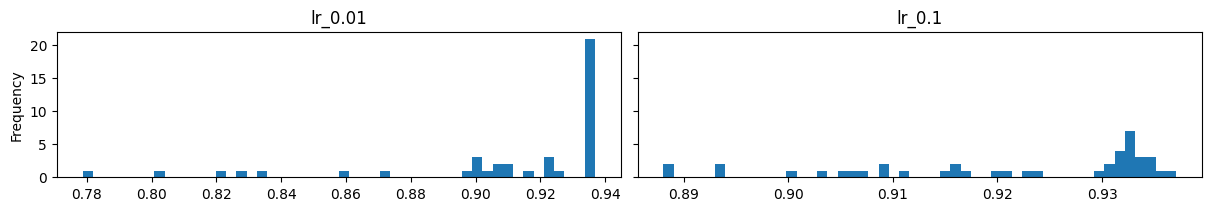

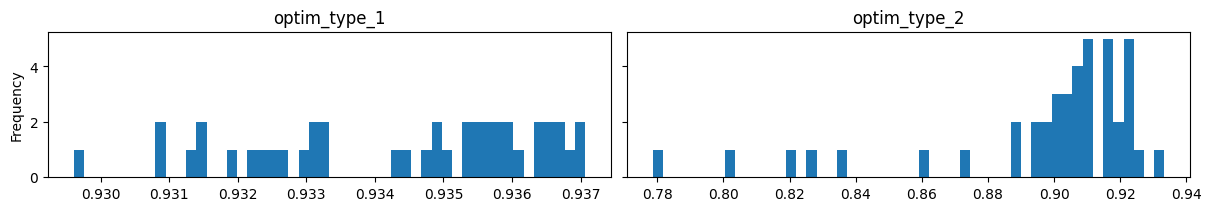

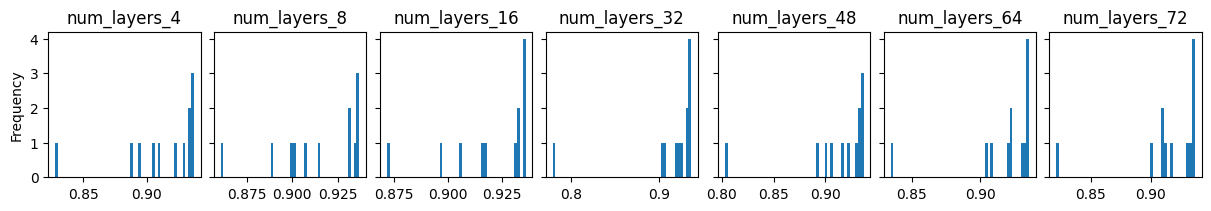

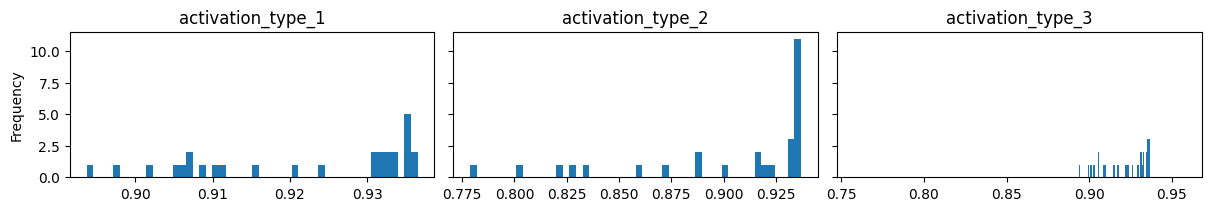

In [35]:
accuracy_desc = sorted_results['mean_accuracy'].astype('float32').describe()
xlimit_range = [accuracy_desc['min'] - accuracy_desc['std'], accuracy_desc['max'] + accuracy_desc['std']]
for hperparameter_name in turning_parameters:
    parameter_group = sorted_results.groupby(hperparameter_name)
    fix, axs = pyplot.subplots(1, len(parameter_group), layout='constrained', sharex=False, sharey=True, figsize=(12,2))
    for i, g in enumerate(parameter_group):
        g[1]['mean_accuracy'].astype('float32').plot(kind='hist',bins=50, subplots=True,sharex=False,sharey=True,ax=axs[i])
        axs[i].set_title(f"{hperparameter_name}_{g[0]}")
        
pyplot.xlim(xlimit_range)
pyplot.show()

In [36]:
sorted_results_file = f"{get_filename_of_ipynb()}_sorted_results.csv"
sorted_results = pd.read_csv(sorted_results_file, dtype='str')
best_config = sorted_results.loc[0]
print(best_config)

Unnamed: 0                         19
mean_accuracy      0.9370654993514915
trial_id                  9dbc7_00019
lr                                0.1
momentum           0.8725056264596475
optim_type                          1
num_layers                         32
activation_type                     2
Name: 0, dtype: object


In [37]:
import math 
from sklearn.metrics import mean_squared_error

pd.set_option('display.precision', 5)

model, config = load_model(f"{get_filename_of_ipynb()}.pt")
model.to(device)

train_loader, test_loader, features_size = prepare_dataloader()
model.eval()

(trainAccuracy, trainF1)= eval_dl_method(model, train_loader, device=device)
(testAccuracy, testF1)  = eval_dl_method(model, test_loader, device=device)
print(f"Train Accuracy: {trainAccuracy:.2f}\nTest Accuracy: {testAccuracy:.5f}")
print(f"Train F1: {trainF1:.2f}\nTest F1: {testF1:.5f}")


Train Accuracy: 0.95
Test Accuracy: 0.94358
Train F1: 0.96
Test F1: 0.95426
